# Indian Pines : EDA 

**Dans ce notebook, nous réalisons une analyse exploratoire des données hyperspectrales Indian Pines. Nous chargeons et visualisons les données (200 bandes spectrales, 16 classes), analysons les statistiques descriptives par bande, calculons la matrice de corrélation entre bandes pour identifier les redondances, effectuons une ANOVA pour trouver les bandes les plus discriminantes entre classes, et visualisons les signatures spectrales moyennes par classe ainsi que les matrices de distance pour évaluer la séparabilité des classes.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway
import os
from sklearn.preprocessing import StandardScaler

In [2]:
# Affichage du contenu du répertoire d'entrée pour vérifier les fichiers importés
print("Fichiers disponibles:")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Fichiers disponibles:
/kaggle/input/indian/Indian_pines_corrected.mat
/kaggle/input/indian/Indian_pines.mat
/kaggle/input/indian/Indian_pines_gt.mat


In [3]:
# Charger les données
data_path = '/kaggle/input/indian/Indian_pines.mat'  # Données originales
corrected_data_path = '/kaggle/input/indian/Indian_pines_corrected.mat'  # Données corrigées
gt_path = '/kaggle/input/indian/Indian_pines_gt.mat'  # Vérité terrain

In [4]:
# Chargement des données
data = sio.loadmat(data_path)
corrected_data = sio.loadmat(corrected_data_path)
gt = sio.loadmat(gt_path)

In [5]:
# Afficher les clés des matrices chargées pour comprendre leur structure
print("\nClés dans le fichier de données original:")
print(data.keys())
print("\nClés dans le fichier de données corrigées:")
print(corrected_data.keys())
print("\nClés dans le fichier de vérité terrain:")
print(gt.keys())


Clés dans le fichier de données original:
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines'])

Clés dans le fichier de données corrigées:
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])

Clés dans le fichier de vérité terrain:
dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])


In [6]:
# Extraire les données hyperspectrales et la vérité terrain
hyperspectral_data = corrected_data['indian_pines_corrected'] if 'indian_pines_corrected' in corrected_data else list(corrected_data.values())[3]
groundtruth = gt['indian_pines_gt'] if 'indian_pines_gt' in gt else list(gt.values())[3]

In [7]:
# Afficher la forme des données
print("\nForme des données hyperspectrales:", hyperspectral_data.shape)
print("Forme de la vérité terrain:", groundtruth.shape)


Forme des données hyperspectrales: (145, 145, 200)
Forme de la vérité terrain: (145, 145)


In [8]:
# Définir les noms des classes
class_names = [
    'Background',
    'Alfalfa',
    'Corn-notill',
    'Corn-mintill',
    'Corn',
    'Grass-pasture',
    'Grass-trees',
    'Grass-pasture-mowed',
    'Hay-windrowed',
    'Oats',
    'Soybean-notill',
    'Soybean-mintill',
    'Soybean-clean',
    'Wheat',
    'Woods',
    'Buildings-Grass-Trees-Drives',
    'Stone-Steel-Towers'
]

In [9]:
# Comptage des pixels par classe
unique_classes, class_counts = np.unique(groundtruth, return_counts=True)
print("\nDistribution des classes:")
for i, count in enumerate(class_counts):
    if i < len(class_names):
        print(f"Classe {i}: {class_names[i]} - {count} pixels")
    else:
        print(f"Classe {i}: Unknown - {count} pixels")


Distribution des classes:
Classe 0: Background - 10776 pixels
Classe 1: Alfalfa - 46 pixels
Classe 2: Corn-notill - 1428 pixels
Classe 3: Corn-mintill - 830 pixels
Classe 4: Corn - 237 pixels
Classe 5: Grass-pasture - 483 pixels
Classe 6: Grass-trees - 730 pixels
Classe 7: Grass-pasture-mowed - 28 pixels
Classe 8: Hay-windrowed - 478 pixels
Classe 9: Oats - 20 pixels
Classe 10: Soybean-notill - 972 pixels
Classe 11: Soybean-mintill - 2455 pixels
Classe 12: Soybean-clean - 593 pixels
Classe 13: Wheat - 205 pixels
Classe 14: Woods - 1265 pixels
Classe 15: Buildings-Grass-Trees-Drives - 386 pixels
Classe 16: Stone-Steel-Towers - 93 pixels


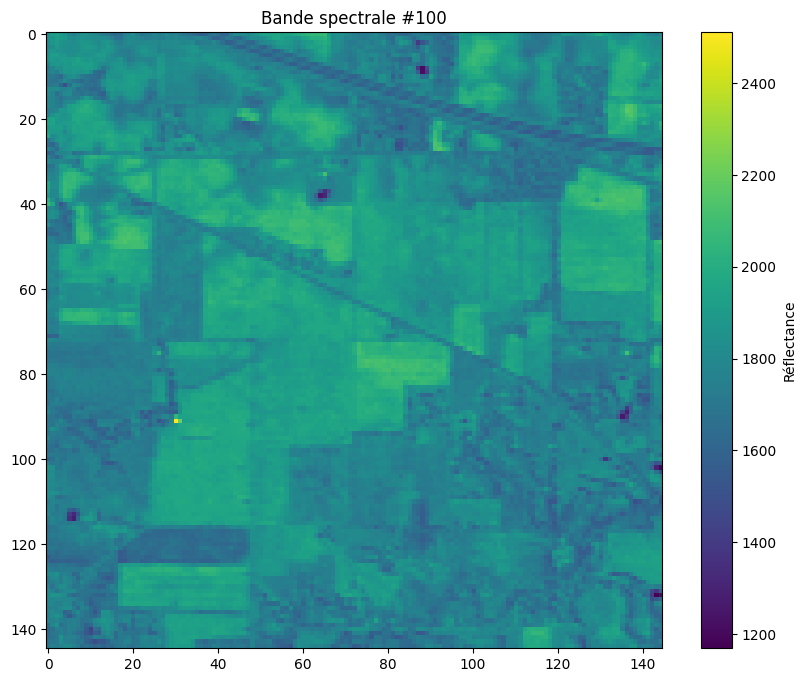

In [10]:
# Visualiser une bande spectrale
plt.figure(figsize=(10, 8))
plt.imshow(hyperspectral_data[:, :, 100], cmap='viridis')
plt.colorbar(label='Réflectance')
plt.title('Bande spectrale #100')
plt.show()

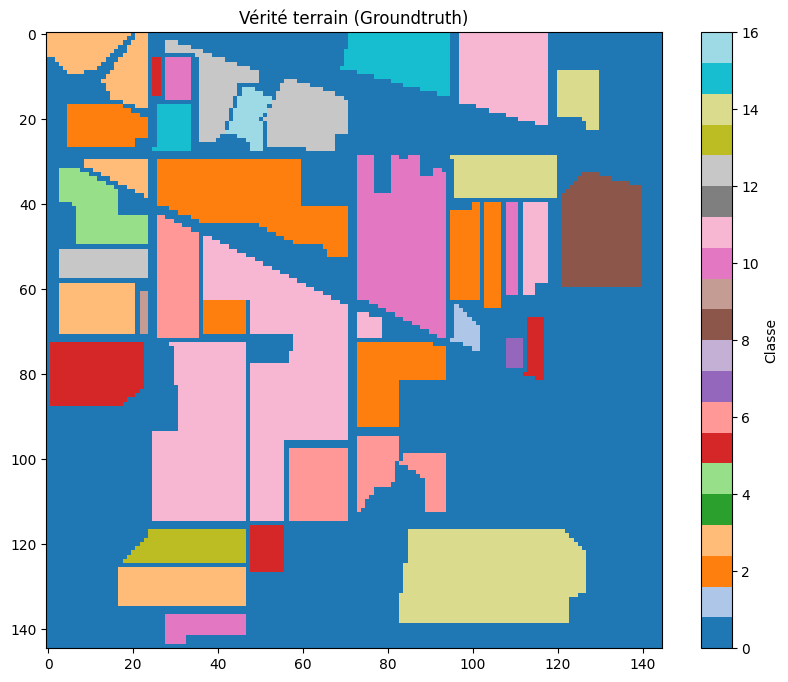

In [11]:
# Visualiser la vérité terrain
plt.figure(figsize=(10, 8))
plt.imshow(groundtruth, cmap='tab20')
plt.colorbar(label='Classe')
plt.title('Vérité terrain (Groundtruth)')
plt.show()

In [12]:
# 1. Analyse de la distribution des intensités par bande
# Reshape les données pour faciliter l'analyse (chaque ligne = un pixel, chaque colonne = une bande)
pixels = hyperspectral_data.reshape(-1, hyperspectral_data.shape[2])
classes = groundtruth.flatten()

In [13]:
# Statistiques descriptives sur les intensités des bandes
bands_stats = pd.DataFrame({
    'Band': range(pixels.shape[1]),
    'Min': np.min(pixels, axis=0),
    'Max': np.max(pixels, axis=0),
    'Mean': np.mean(pixels, axis=0),
    'Median': np.median(pixels, axis=0),
    'Std': np.std(pixels, axis=0)
})

In [14]:
# Afficher les statistiques pour quelques bandes
print("Statistiques des bandes:")
print(bands_stats.head(10))

Statistiques des bandes:
   Band   Min   Max         Mean  Median         Std
0     0  2560  4536  2957.363472  2780.0  354.910267
1     1  2709  5744  4091.321237  4106.0  230.384526
2     2  3649  6361  4277.502259  4237.0  257.821508
3     3  2810  6362  4169.956671  4126.0  280.754577
4     4  3840  7153  4516.678668  4478.0  346.027754
5     5  4056  7980  4790.595149  4754.0  414.372283
6     6  4004  8284  4848.317574  4808.0  469.236508
7     7  3865  8128  4714.732509  4666.0  491.716655
8     8  3775  8194  4668.904828  4632.0  533.220174
9     9  2792  7928  4439.065541  4404.0  539.895355


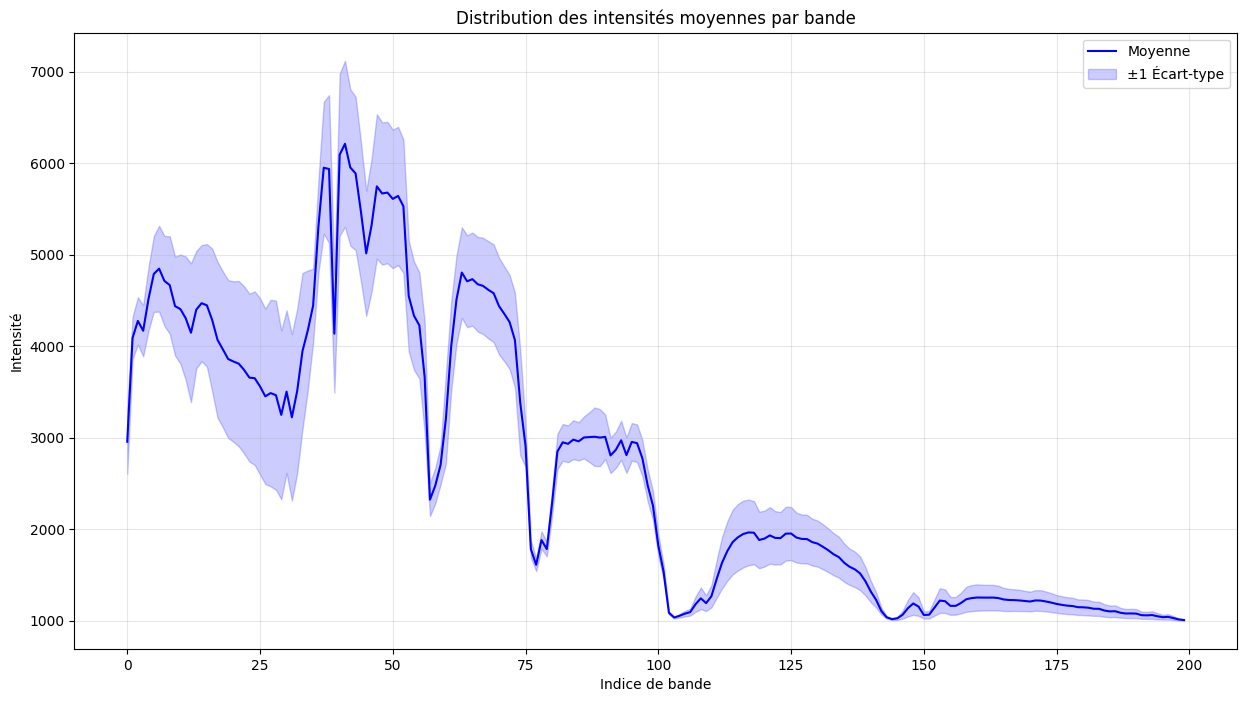

In [15]:
# Visualiser la distribution des intensités pour toutes les bandes
plt.figure(figsize=(15, 8))
plt.plot(bands_stats['Band'], bands_stats['Mean'], 'b-', label='Moyenne')
plt.fill_between(bands_stats['Band'], 
                 bands_stats['Mean'] - bands_stats['Std'], 
                 bands_stats['Mean'] + bands_stats['Std'], 
                 alpha=0.2, color='b', label='±1 Écart-type')
plt.xlabel('Indice de bande')
plt.ylabel('Intensité')
plt.title('Distribution des intensités moyennes par bande')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Calcul de la matrice de corrélation en utilisant tous les pixels...
Calcul terminé!


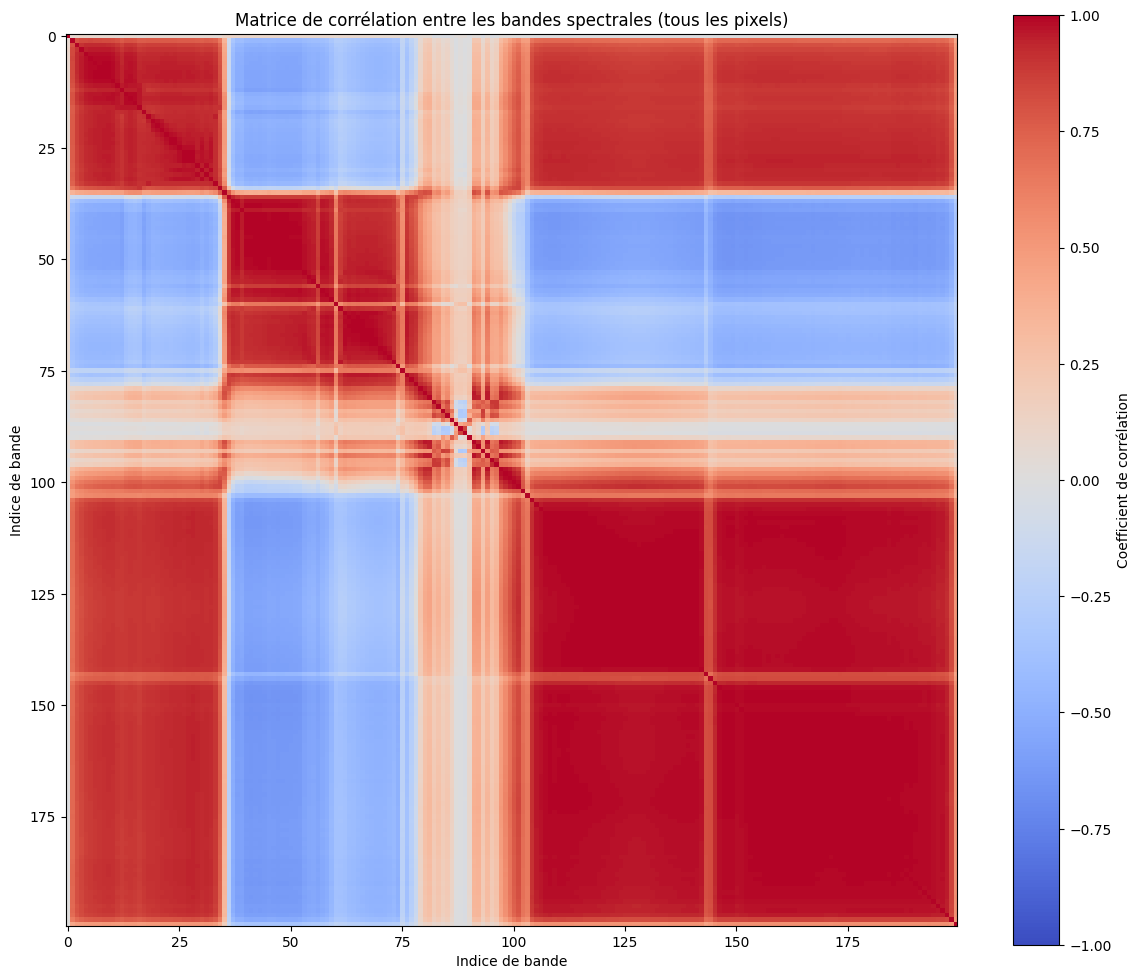

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


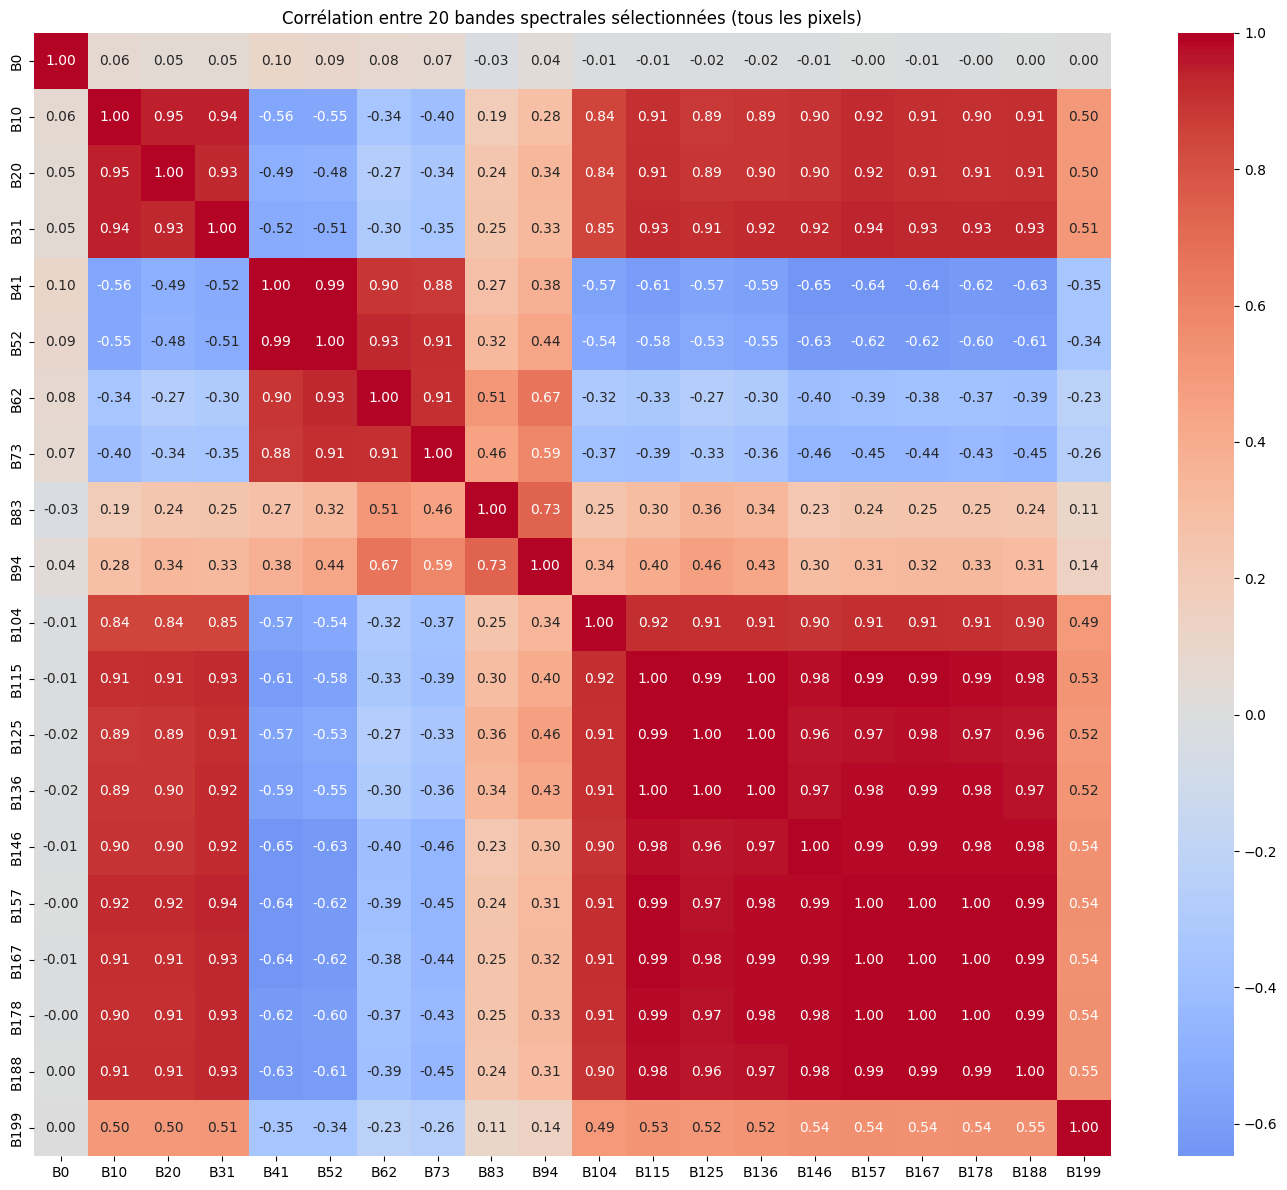

In [16]:
# 2. Analyse des corrélations entre les bandes - en utilisant TOUS les pixels

# Calculer la matrice de corrélation en utilisant tous les pixels
print("Calcul de la matrice de corrélation en utilisant tous les pixels...")
corr_matrix = np.corrcoef(pixels.T)
print("Calcul terminé!")

# Visualiser la matrice de corrélation complète
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Coefficient de corrélation')
plt.title('Matrice de corrélation entre les bandes spectrales (tous les pixels)')
plt.xlabel('Indice de bande')
plt.ylabel('Indice de bande')
plt.tight_layout()
plt.show()

# Pour une visualisation plus claire, on peut sélectionner quelques bandes
# Sélectionner 20 bandes réparties uniformément
selected_bands = np.linspace(0, pixels.shape[1]-1, 20, dtype=int)
corr_subset = corr_matrix[selected_bands][:, selected_bands]

# Créer une heatmap avec des étiquettes plus lisibles
plt.figure(figsize=(14, 12))
sns.heatmap(corr_subset, cmap='coolwarm', center=0, annot=True, fmt='.2f',
            xticklabels=[f'B{i}' for i in selected_bands],
            yticklabels=[f'B{i}' for i in selected_bands])
plt.title('Corrélation entre 20 bandes spectrales sélectionnées (tous les pixels)')
plt.tight_layout()
plt.show()

<ipython-input-17-9c42402b981c>:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_results = pd.concat([anova_results, pd.DataFrame([new_row])], ignore_index=True)


Les 10 bandes les plus discriminantes selon l'ANOVA:
    Bande  F_statistic  p_value
148   148  6191.739670      0.0
149   149  6089.143269      0.0
147   147  6040.286704      0.0
153   153  6009.266830      0.0
152   152  6009.140727      0.0
167   167  5872.117911      0.0
154   154  5859.031959      0.0
155   155  5788.653017      0.0
164   164  5782.640892      0.0
165   165  5780.267287      0.0


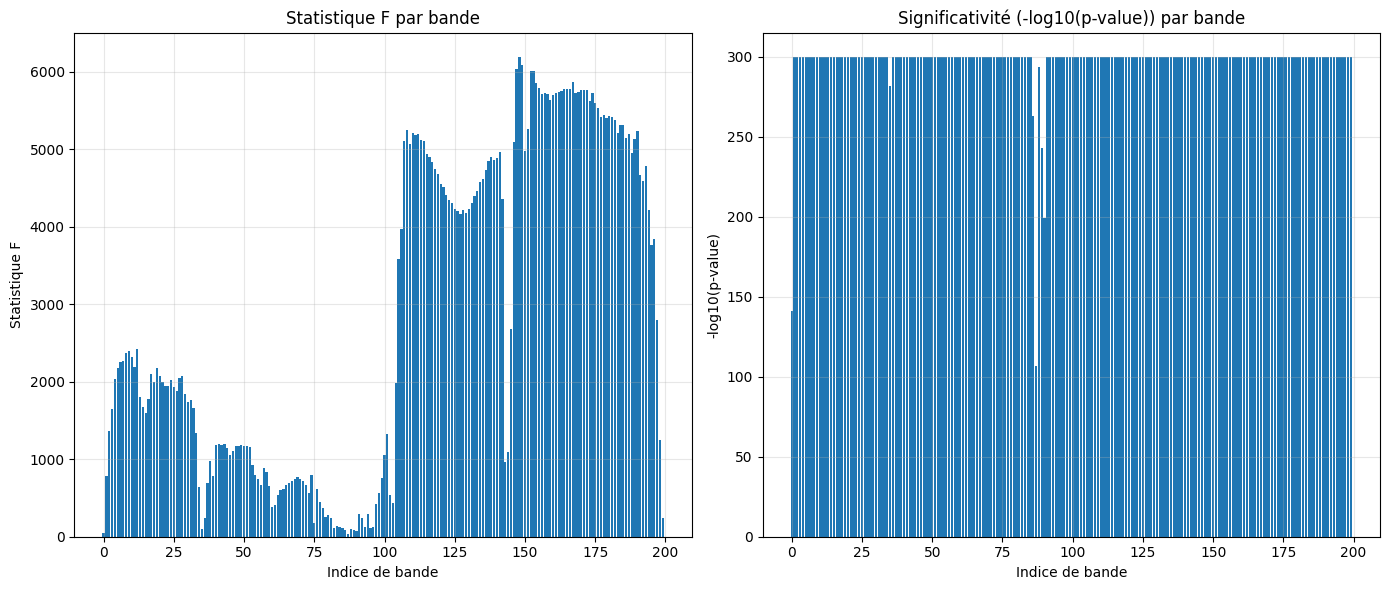

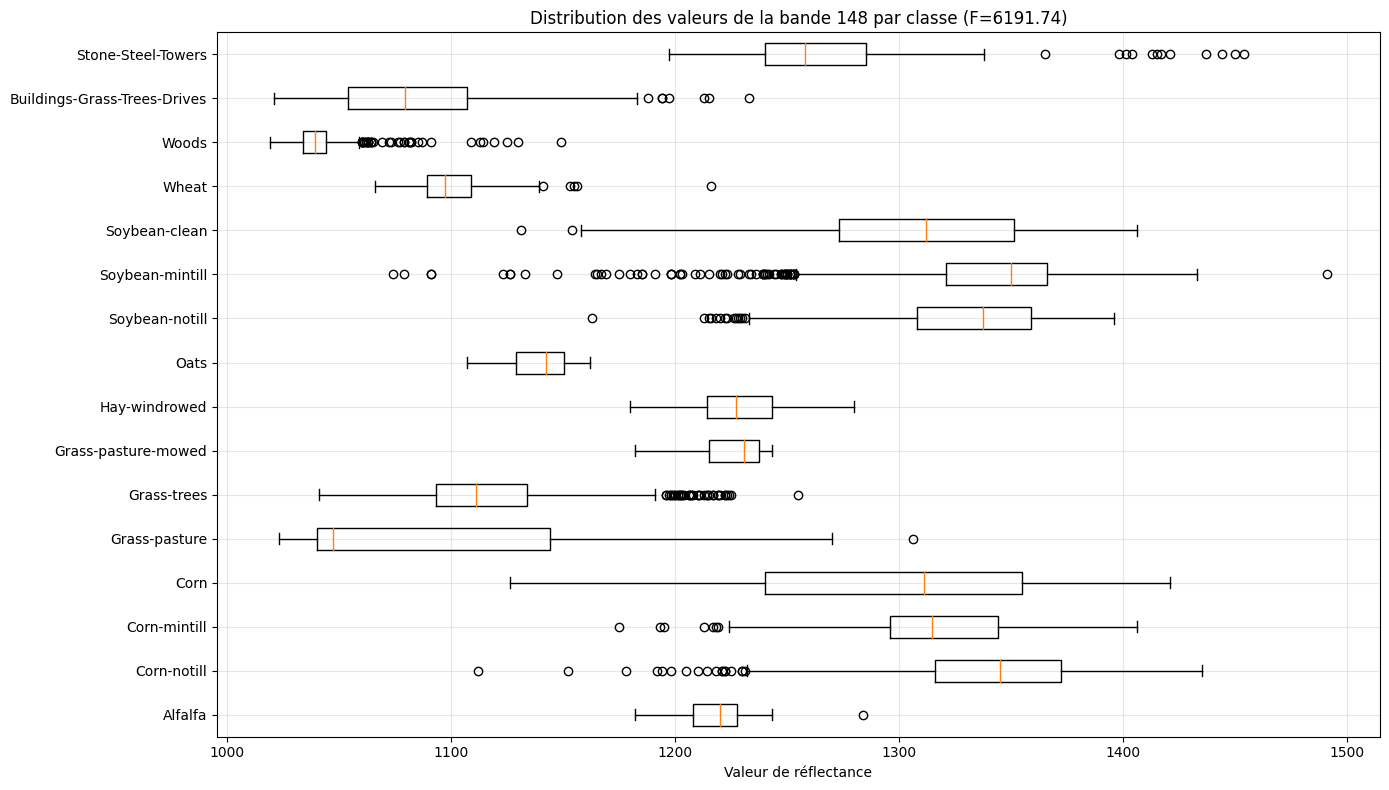

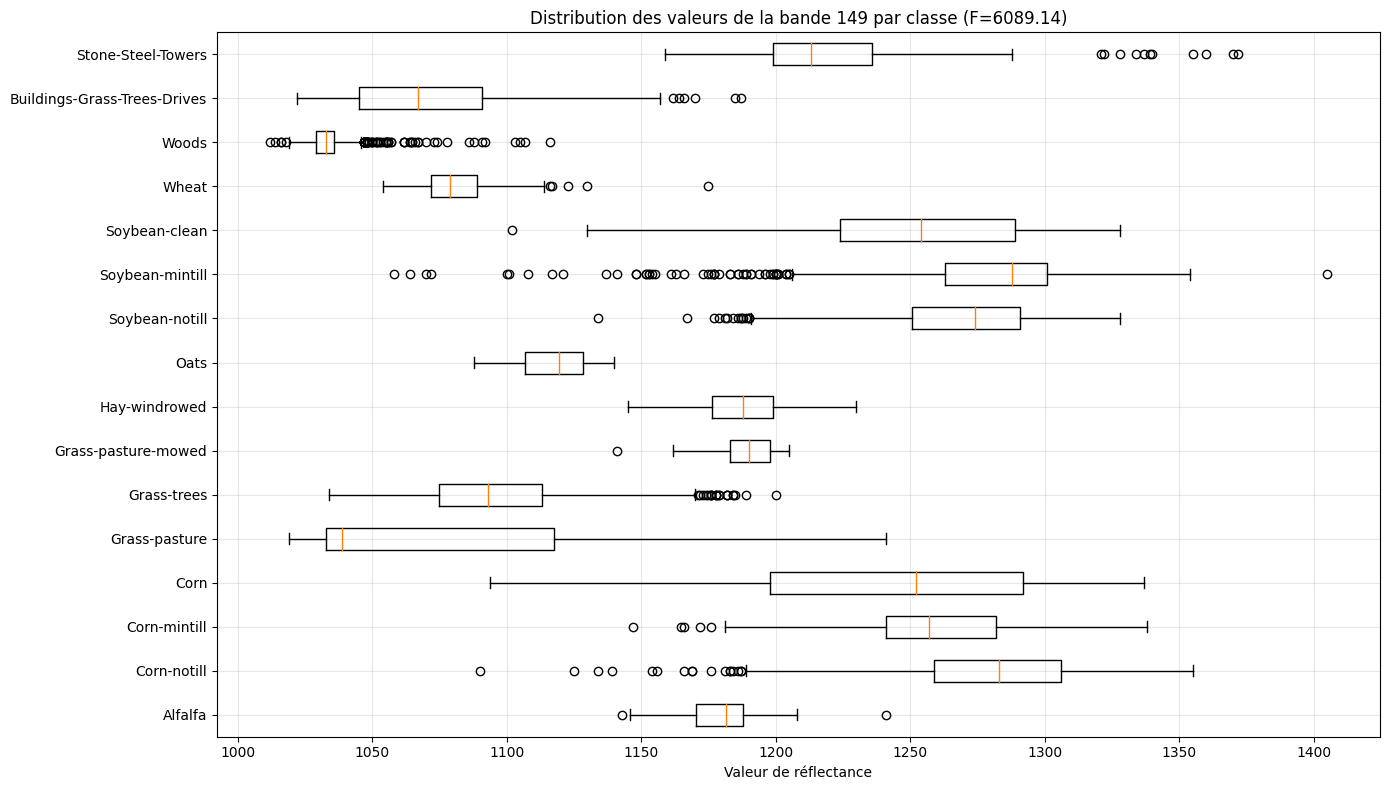

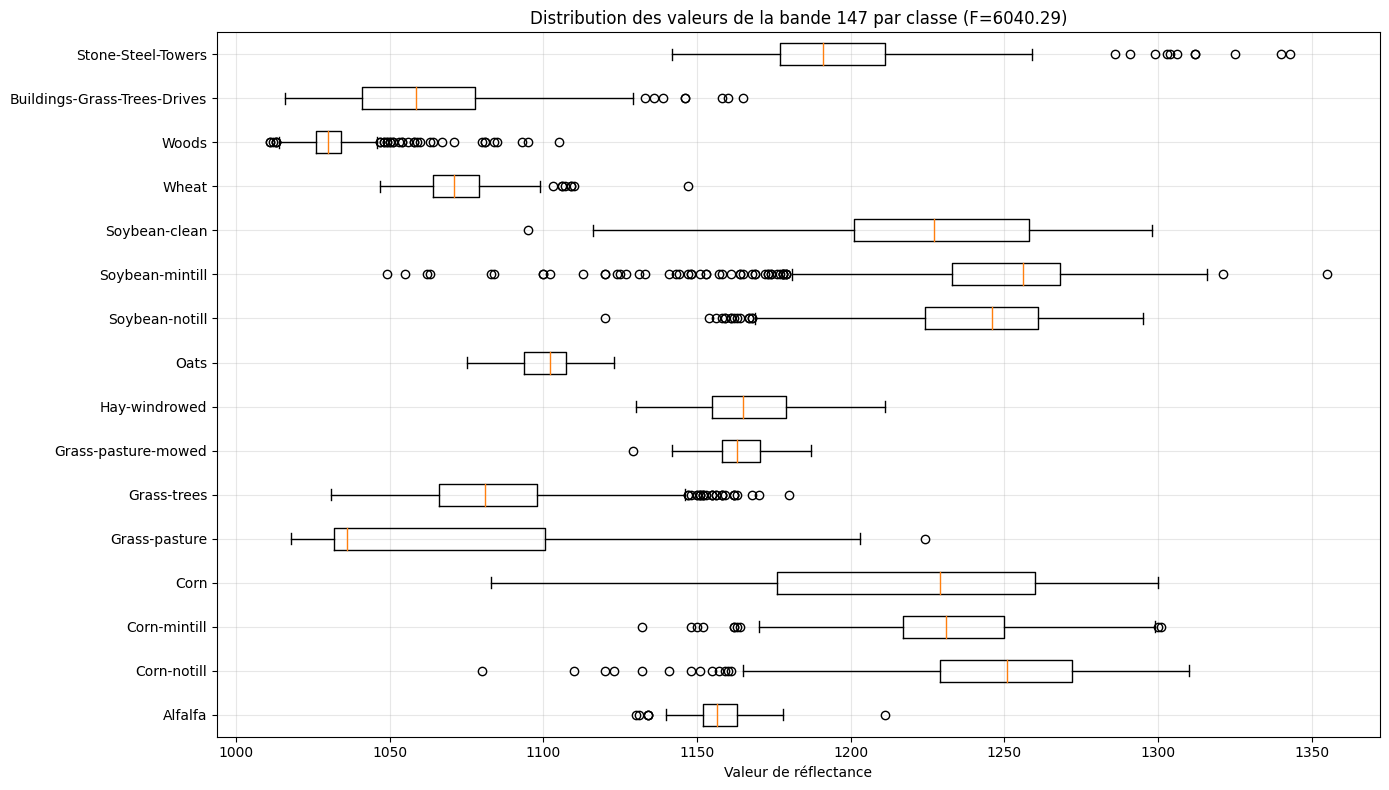

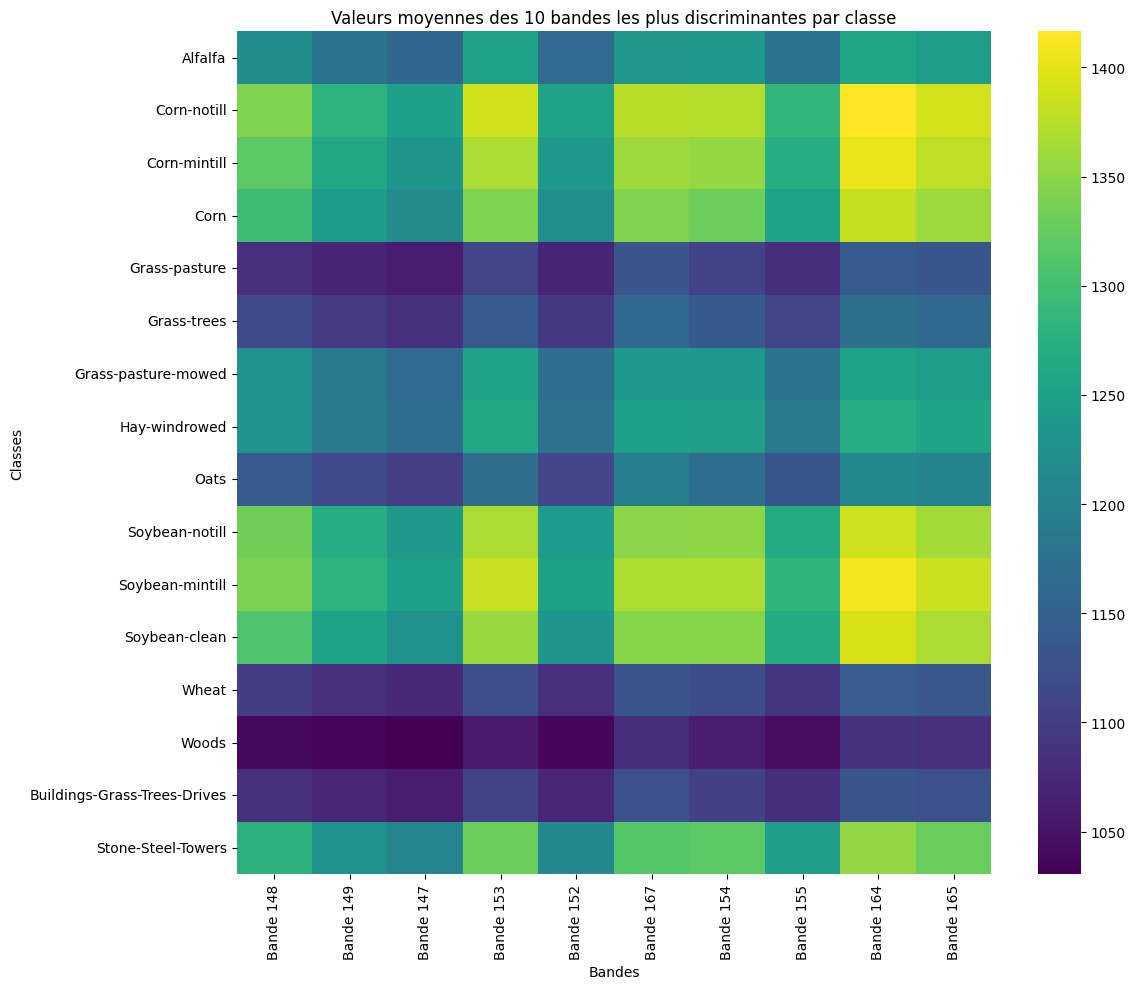

In [17]:
# 3. Corrélations entre les bandes et les classes (ANOVA)
from scipy.stats import f_oneway
import pandas as pd

# Créer un DataFrame pour stocker les résultats de l'ANOVA
anova_results = pd.DataFrame(columns=['Bande', 'F_statistic', 'p_value'])

# Exclure les pixels avec classe 0 (généralement le fond)
mask = classes > 0
valid_pixels = pixels[mask]
valid_classes = classes[mask]

# Boucle sur chaque bande
for band_idx in range(pixels.shape[1]):
    # Organiser les valeurs de cette bande par classe
    class_values = {}
    for class_idx in np.unique(valid_classes):
        class_values[class_idx] = valid_pixels[valid_classes == class_idx, band_idx]
    
    # Vérifier qu'il y a suffisamment d'échantillons dans chaque classe
    valid_class_values = [vals for vals in class_values.values() if len(vals) >= 5]
    
    if len(valid_class_values) >= 2:  # Au moins 2 groupes pour l'ANOVA
        # Effectuer l'ANOVA
        f_stat, p_val = f_oneway(*valid_class_values)
        
        # Stocker les résultats
        new_row = {
            'Bande': band_idx,
            'F_statistic': f_stat,
            'p_value': p_val
        }
        anova_results = pd.concat([anova_results, pd.DataFrame([new_row])], ignore_index=True)

# Trier les résultats par valeur F décroissante
anova_results = anova_results.sort_values('F_statistic', ascending=False)

# Afficher les 10 bandes les plus discriminantes
print("Les 10 bandes les plus discriminantes selon l'ANOVA:")
print(anova_results.head(10))

# Visualiser les statistiques F pour toutes les bandes
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(anova_results['Bande'], anova_results['F_statistic'])
plt.title('Statistique F par bande')
plt.xlabel('Indice de bande')
plt.ylabel('Statistique F')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Remplacer les p-values de 0 par une très petite valeur pour éviter l'erreur de log(0)
p_values_adj = anova_results['p_value'].copy()
p_values_adj = p_values_adj.replace(0, 1e-300)  # Remplacer les 0 par une valeur très petite
plt.bar(anova_results['Bande'], -np.log10(p_values_adj))
plt.title('Significativité (-log10(p-value)) par bande')
plt.xlabel('Indice de bande')
plt.ylabel('-log10(p-value)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Visualiser la distribution des valeurs pour les bandes les plus discriminantes
top_bands = anova_results.head(3)['Bande'].astype(int).tolist()

for band_idx in top_bands:
    plt.figure(figsize=(14, 8))
    
    # Créer un boxplot par classe pour cette bande
    class_data = []
    class_labels = []
    
    for class_idx in sorted(np.unique(valid_classes)):
        values = valid_pixels[valid_classes == class_idx, band_idx]
        if len(values) >= 5:  # S'assurer qu'il y a suffisamment d'échantillons
            class_data.append(values)
            class_labels.append(class_names[class_idx] if class_idx < len(class_names) else f"Classe {class_idx}")
    
    plt.boxplot(class_data, labels=class_labels, vert=False)
    plt.title(f'Distribution des valeurs de la bande {band_idx} par classe (F={anova_results[anova_results["Bande"]==band_idx]["F_statistic"].values[0]:.2f})')
    plt.xlabel('Valeur de réflectance')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Créer une heatmap des valeurs moyennes par classe pour les 10 meilleures bandes
top_10_bands = anova_results.head(10)['Bande'].astype(int).tolist()
class_means = np.zeros((len(np.unique(valid_classes)), len(top_10_bands)))

for i, class_idx in enumerate(sorted(np.unique(valid_classes))):
    for j, band_idx in enumerate(top_10_bands):
        class_means[i, j] = np.mean(valid_pixels[valid_classes == class_idx, band_idx])

plt.figure(figsize=(12, 10))
sns.heatmap(class_means, cmap='viridis', 
            xticklabels=[f'Bande {b}' for b in top_10_bands],
            yticklabels=[class_names[i] if i < len(class_names) else f"Classe {i}" for i in sorted(np.unique(valid_classes))])
plt.title('Valeurs moyennes des 10 bandes les plus discriminantes par classe')
plt.xlabel('Bandes')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

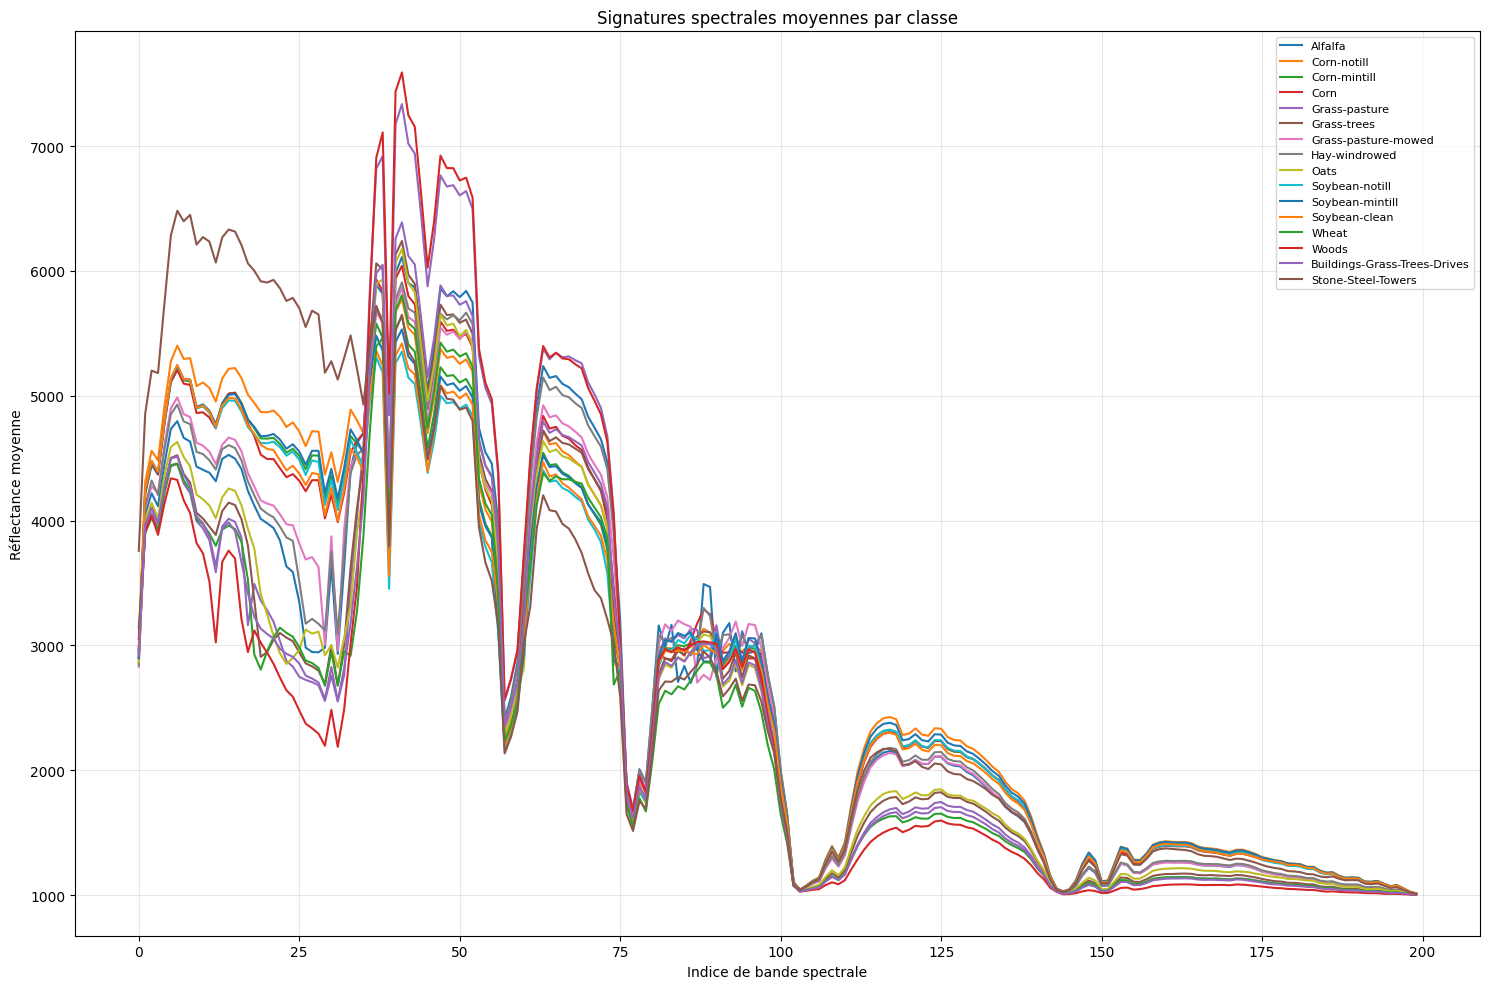

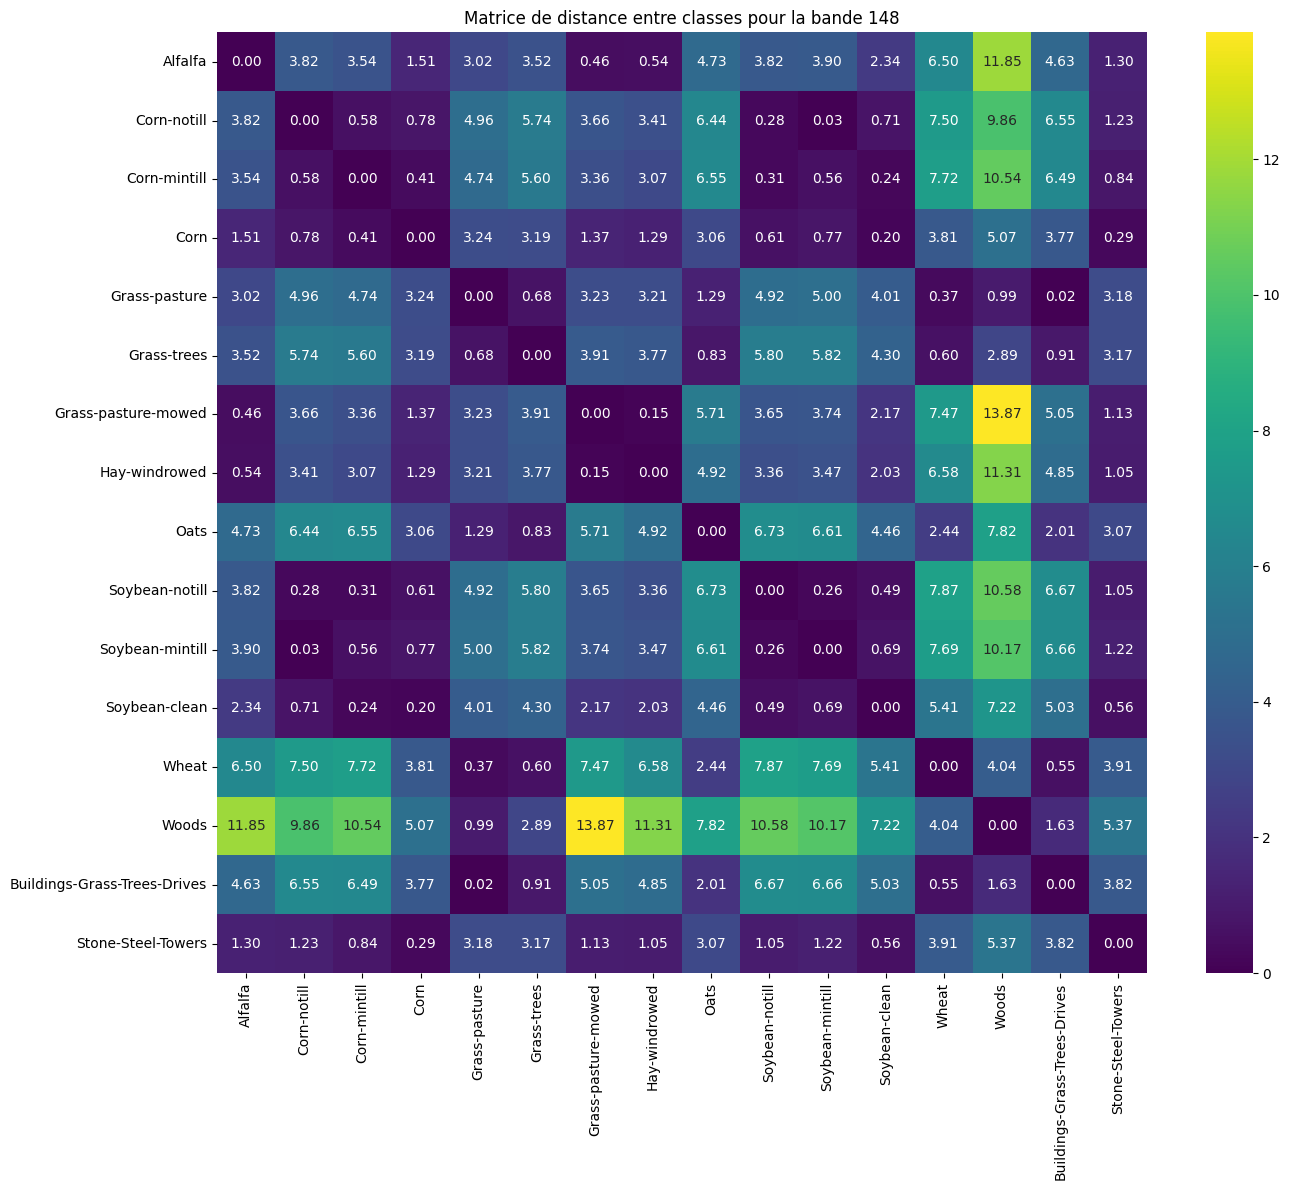

In [18]:
# 4. Analyse de la séparabilité entre les classes

# 4.1 Signatures spectrales moyennes par classe
plt.figure(figsize=(15, 10))

# Calculer et tracer la signature spectrale moyenne pour chaque classe (sauf le fond)
for class_idx in sorted(np.unique(valid_classes)):
    # Récupérer tous les pixels de cette classe
    class_pixels = valid_pixels[valid_classes == class_idx]
    # Calculer la signature spectrale moyenne
    mean_spectrum = np.mean(class_pixels, axis=0)
    # Tracer la signature moyenne
    plt.plot(range(mean_spectrum.shape[0]), mean_spectrum, 
             label=class_names[class_idx] if class_idx < len(class_names) else f"Classe {class_idx}")

plt.title('Signatures spectrales moyennes par classe')
plt.xlabel('Indice de bande spectrale')
plt.ylabel('Réflectance moyenne')
plt.grid(alpha=0.3)
plt.legend(loc='best', fontsize=8)
plt.tight_layout()
plt.show()

# 4.2 Matrice de distances entre classes pour la meilleure bande
best_band = int(anova_results.iloc[0]['Bande'])

# Créer une matrice de distances entre classes
num_classes = len(np.unique(valid_classes))
distance_matrix = np.zeros((num_classes, num_classes))
class_indices = sorted(np.unique(valid_classes))

for i, class1 in enumerate(class_indices):
    for j, class2 in enumerate(class_indices):
        # Récupérer les valeurs pour les deux classes
        class1_values = valid_pixels[valid_classes == class1, best_band]
        class2_values = valid_pixels[valid_classes == class2, best_band]
        
        # Calculer les moyennes et écarts-types
        mean1, std1 = np.mean(class1_values), np.std(class1_values)
        mean2, std2 = np.mean(class2_values), np.std(class2_values)
        
        # Calculer la distance normalisée entre les classes
        if i == j:
            distance_matrix[i, j] = 0
        else:
            # Distance normalisée
            dist = abs(mean1 - mean2) / np.sqrt((std1**2 + std2**2)/2)
            distance_matrix[i, j] = dist

# Créer une heatmap des distances entre classes
plt.figure(figsize=(14, 12))
sns.heatmap(distance_matrix, cmap='viridis', 
            xticklabels=[class_names[i] if i < len(class_names) else f"Classe {i}" for i in class_indices],
            yticklabels=[class_names[i] if i < len(class_names) else f"Classe {i}" for i in class_indices],
            annot=True, fmt='.2f')
plt.title(f'Matrice de distance entre classes pour la bande {best_band}')
plt.tight_layout()
plt.show()